In [1]:
import tensorflow as tf

IMAGE_SHAPE = (320, 320, 3)
BATCH_SIZE = 5
DATA_SET_SIZE = 15000

def create_model():
    base_learning_rate = 0.0001
    pretrined_resnet = tf.keras.applications.densenet.DenseNet201(include_top=False, weights='imagenet', input_tensor=None, input_shape=IMAGE_SHAPE, pooling=None, classes=1000)
    pretrined_resnet.trainable = False
    current_layer = pretrined_resnet.output
    current_layer = tf.keras.layers.AveragePooling2D()(current_layer)
    current_layer = tf.keras.layers.Flatten()(current_layer)
    current_layer = tf.keras.layers.Dense(64, activation="relu")(current_layer)
    current_layer = tf.keras.layers.Dropout(0.5)(current_layer)
    current_layer = tf.keras.layers.Dense(2, activation="softmax")(current_layer)
  
    our_model = tf.keras.models.Model(inputs=pretrined_resnet.input, outputs=current_layer)
  
    our_model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate), 
                      loss='binary_crossentropy', metrics=['accuracy'])
    return our_model


In [2]:
import pandas as pd
metadata_train_full = pd.read_csv('CheXpert-v1.0-small/train.csv')
metadata_valid = pd.read_csv('CheXpert-v1.0-small/valid.csv')

In [3]:
metadata_train_sick = metadata_train_full[metadata_train_full['No Finding'] != 1.0][:int(DATA_SET_SIZE/2)]
metadata_train_healthy = metadata_train_full[metadata_train_full['No Finding'] == 1.0][:int(DATA_SET_SIZE/2)]
metadata_train = pd.concat([metadata_train_sick, metadata_train_healthy])
metadata_train.count()

Path                          15000
Sex                           15000
Age                           15000
Frontal/Lateral               15000
AP/PA                         11224
No Finding                     7500
Enlarged Cardiomediastinum     4607
Cardiomegaly                   3182
Lung Opacity                   5016
Lung Lesion                     630
Edema                          4539
Consolidation                  5615
Pneumonia                      1404
Atelectasis                    2547
Pneumothorax                   6735
Pleural Effusion               8916
Pleural Other                   297
Fracture                        856
Support Devices                6552
dtype: int64

In [4]:
import matplotlib.pyplot as plt
pa_data = metadata_train[metadata_train['AP/PA'].isin(['AP', 'PA'])]
train_pa = metadata_train[metadata_train['AP/PA'].isin(['AP', 'PA'])]
valid_pa = metadata_valid[metadata_valid['AP/PA'].isin(['AP', 'PA'])]

def show_batch(image, label):
    plt.imshow(image)
    print(label)
    

In [5]:
class DataProcessor():
    def __init__(self, from_dataframe):
        self.dataset = tf.data.Dataset.from_tensor_slices((from_dataframe['Path'].values, from_dataframe['No Finding'].values))
        for path, lbl in self.dataset.take(1):            
            print(path)
            print(lbl)
    
    def _decode_image(self, img):
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)
        return tf.image.resize(img, [IMAGE_SHAPE[0], IMAGE_SHAPE[1]])
    
    def _pre_proces_images(self, file_path, label):
        img = tf.io.read_file(file_path)
        img = self._decode_image(img)
        resulted_label = [0.0, 1.0]
        if label == 1.0:
            resulted_label = [1.0, 0.0]
        return img, resulted_label
    
    def prepare_dataset(self):
        self.dataset = self.dataset.map(self._pre_proces_images)
        self.dataset = self.dataset.cache()
        self.dataset = self.dataset.shuffle(buffer_size = DATA_SET_SIZE+1, reshuffle_each_iteration=True )
        self.dataset = self.dataset.repeat()
        self.dataset = self.dataset.batch(BATCH_SIZE)
        self.dataset = self.dataset.prefetch(buffer_size= tf.data.experimental.AUTOTUNE)
        
        return self.dataset

train_ds = DataProcessor(from_dataframe = train_pa).prepare_dataset()
valid_ds = DataProcessor(from_dataframe = valid_pa).prepare_dataset()

tf.Tensor(b'CheXpert-v1.0-small/train/patient00002/study2/view1_frontal.jpg', shape=(), dtype=string)
tf.Tensor(nan, shape=(), dtype=float64)
tf.Tensor(b'CheXpert-v1.0-small/valid/patient64541/study1/view1_frontal.jpg', shape=(), dtype=string)
tf.Tensor(0.0, shape=(), dtype=float64)


tf.Tensor([0. 1.], shape=(2,), dtype=float32)


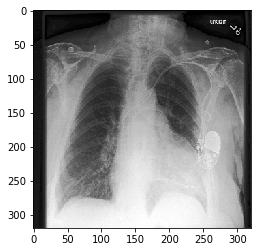

In [6]:
for image, label in train_ds.take(1):
    show_batch(image[0], label[0])

In [7]:
current_model = create_model()

In [8]:
history_mobile = current_model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=75,
    steps_per_epoch  = 100,
    validation_steps = 20
)

Train for 100 steps, validate for 20 steps
Epoch 1/75
100/100 [==============================] - 34s 341ms/step - loss: 0.9651 - accuracy: 0.5900 - val_loss: 0.6100 - val_accuracy: 0.7900
Epoch 2/75
100/100 [==============================] - 8s 81ms/step - loss: 0.6526 - accuracy: 0.6620 - val_loss: 0.7152 - val_accuracy: 0.4000
Epoch 3/75
100/100 [==============================] - 8s 81ms/step - loss: 0.6105 - accuracy: 0.6740 - val_loss: 0.5882 - val_accuracy: 0.8600
Epoch 4/75
100/100 [==============================] - 8s 81ms/step - loss: 0.6378 - accuracy: 0.6780 - val_loss: 0.5962 - val_accuracy: 0.8400
Epoch 5/75
100/100 [==============================] - 8s 81ms/step - loss: 0.6203 - accuracy: 0.6720 - val_loss: 0.5274 - val_accuracy: 0.9200
Epoch 6/75
100/100 [==============================] - 8s 80ms/step - loss: 0.6288 - accuracy: 0.6520 - val_loss: 0.5687 - val_accuracy: 0.9000
Epoch 7/75
100/100 [==============================] - 8s 81ms/step - loss: 0.6202 - accuracy: 0.6

In [9]:

current_model.save_weights('as_densenet201_healthy_0510_1.h5')

In [10]:
for file_name in train_pa[train_pa['No Finding'] == 1.0][:100]['Path'].tolist():
    img = tf.io.read_file(file_name)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMAGE_SHAPE[0], IMAGE_SHAPE[1]])
    img_input = tf.expand_dims(img, 0)
    result = current_model.predict(img_input)
    print(result)

[[0.63700265 0.36299738]]
[[0.6821621 0.3178379]]
[[0.7382198  0.26178017]]
[[0.64765465 0.35234532]]
[[0.7516387 0.2483613]]
[[0.7762362  0.22376381]]
[[0.6005269  0.39947313]]
[[0.5900674  0.40993258]]
[[0.7148977  0.28510228]]
[[0.6707649 0.3292351]]
[[0.51611024 0.48388976]]
[[0.5973668  0.40263316]]
[[0.6281462  0.37185386]]
[[0.59097576 0.40902418]]
[[0.6776488  0.32235122]]
[[0.5135396  0.48646042]]
[[0.66257024 0.33742973]]
[[0.26884922 0.73115075]]
[[0.47482646 0.52517354]]
[[0.6663884  0.33361164]]
[[0.652317 0.347683]]
[[0.6412115 0.3587885]]
[[0.5829604  0.41703957]]
[[0.5811036  0.41889638]]
[[0.7432418 0.2567582]]
[[0.65007055 0.34992945]]
[[0.5257136  0.47428644]]
[[0.6708288  0.32917115]]
[[0.5352262 0.4647738]]
[[0.5642947 0.4357053]]
[[0.7162075  0.28379253]]
[[0.7339629  0.26603714]]
[[0.53061503 0.46938497]]
[[0.48331767 0.5166824 ]]
[[0.6812478 0.3187522]]
[[0.7988261  0.20117392]]
[[0.6892588  0.31074122]]
[[0.28581116 0.7141889 ]]
[[0.506361 0.493639]]
[[0.794211